In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 

# preprocessing libraries
from fast_ml.model_development import train_valid_test_split

# classifcation model and model selection libraries
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit 

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay
from itertools import cycle
from scipy import interp

# model inspection libraries
import shap
shap.initjs()

warnings.filterwarnings('ignore')

### Read in the data

In [2]:
data = pd.read_csv('../notebooks/data/merged_data.csv')

print(f'Shape of dataframe: {data.shape}')
print('\n')

data.head()

Shape of dataframe: (1305, 558)




,patdeid,admin_location_0,methadone_dose_0,bupe_dose_0,admin_location_1,methadone_dose_1,bupe_dose_1,admin_location_2,methadone_dose_2,bupe_dose_2,...,race_amer_ind,race_Asian,race_Black,race_pacific_isl,race_White,medication,total_visits,tnt,wsu,responder
0,1,1.0,0.0,8.0,1.0,0.0,160.0,1.0,0.0,320.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,20,8,1
1,2,1.0,0.0,8.0,2.0,0.0,48.0,1.0,0.0,48.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,6,0,0
2,3,1.0,30.0,0.0,1.0,170.0,0.0,1.0,310.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,26,0,0,0
3,4,1.0,0.0,16.0,1.0,0.0,152.0,1.0,0.0,192.0,...,0.0,0.0,0.0,0.0,1.0,2.0,26,4,1,0
4,6,1.0,0.0,16.0,1.0,0.0,8.0,1.0,0.0,8.0,...,0.0,0.0,0.0,0.0,1.0,2.0,3,0,0,0


### Create function to remove object columns

In [3]:
# create function to remove object columns
def remove_object_cols(df):
    '''
    This function removes object columns from a dataframe.
    '''
    # create list of object columns
    object_cols = list(df.select_dtypes('object').columns)
    # drop object columns
    df = df.drop(columns=object_cols)
    return df

In [4]:
data = remove_object_cols(data)

data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1305 entries, 0 to 1304
Data columns (total 528 columns):
 #    Column                  Dtype  
---   ------                  -----  
 0    patdeid                 int64  
 1    admin_location_0        float64
 2    methadone_dose_0        float64
 3    bupe_dose_0             float64
 4    admin_location_1        float64
 5    methadone_dose_1        float64
 6    bupe_dose_1             float64
 7    admin_location_2        float64
 8    methadone_dose_2        float64
 9    bupe_dose_2             float64
 10   admin_location_3        float64
 11   methadone_dose_3        float64
 12   bupe_dose_3             float64
 13   admin_location_4        float64
 14   methadone_dose_4        float64
 15   bupe_dose_4             float64
 16   admin_location_5        float64
 17   methadone_dose_5        float64
 18   bupe_dose_5             float64
 19   admin_location_6        float64
 20   methadone_dose_6        float64
 21   bupe_dose_6 

## Remove Features to prevent data leakage
The opiate tests and self reported use for the final month of treatment are removed to prevent data leakage

In [5]:
# define parameters
cols_to_remove = ['patdeid','t_Opiate300_21','t_Opiate300_22','t_Opiate300_23','t_Opiate300_24','sru_opiates_24','wsu','tnt']

# remove columns
data = data.drop(columns=cols_to_remove)

data

,admin_location_0,methadone_dose_0,bupe_dose_0,admin_location_1,methadone_dose_1,bupe_dose_1,admin_location_2,methadone_dose_2,bupe_dose_2,admin_location_3,...,Sex,Ethnicity,race_amer_ind,race_Asian,race_Black,race_pacific_isl,race_White,medication,total_visits,responder
0,1.0,0.0,8.0,1.0,0.0,160.0,1.0,0.0,320.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,26,1
1,1.0,0.0,8.0,2.0,0.0,48.0,1.0,0.0,48.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,26,0
2,1.0,30.0,0.0,1.0,170.0,0.0,1.0,310.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,26,0
3,1.0,0.0,16.0,1.0,0.0,152.0,1.0,0.0,192.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,26,0
4,1.0,0.0,16.0,1.0,0.0,8.0,1.0,0.0,8.0,NaN,...,2.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1300,1.0,30.0,0.0,1.0,270.0,0.0,1.0,390.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,26,1
1301,1.0,0.0,8.0,1.0,0.0,32.0,1.0,0.0,64.0,1.0,...,2.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0,15,0
1302,1.0,30.0,0.0,1.0,690.0,0.0,2.0,1460.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,26,0
1303,1.0,110.0,0.0,1.0,270.0,0.0,1.0,250.0,0.0,1.0,...,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1.0,19,0


### Split the data into training, testing and validation sets

In [6]:
# define parameters
train_size = 0.7
valid_size = 0.1
test_size = 0.2

# split data
X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(data, target = 'responder', 
                                                                            train_size=train_size, valid_size=valid_size, test_size=test_size)

# print shapes of dataframes
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print('\n')
print(f'Shape of X_valid: {X_valid.shape}')
print(f'Shape of y_valid: {y_valid.shape}')
print('\n')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_test: {y_test.shape}')


Shape of X_train: (913, 519)
Shape of y_train: (913,)


Shape of X_valid: (130, 519)
Shape of y_valid: (130,)


Shape of X_test: (262, 519)
Shape of y_test: (262,)


In [7]:
 # use label encoder to encode labels for y_train, y_test and y_val
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_valid)

### Fit the model

In [8]:
def fit_model(X_train, y_train):
    parameters = [
        {'n_estimators':[150,200,300], 'learning_rate':[0.1,0.01,0.001]}
    ]

    grid_search = GridSearchCV(XGBClassifier(), 
                               parameters,
                               verbose=True, 
                               scoring='f1', 
                               cv=StratifiedShuffleSplit(n_splits=5),
                               n_jobs=8)
    grid_search.fit(X_train, y_train)
    
    return grid_search

In [9]:
grid_search = fit_model(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [10]:
# print best score and best params from grid search
print(f'Best score: {grid_search.best_score_}')
print('\n')
print(f'Best params: {grid_search.best_params_}')
print('\n')
print(f'Accuracy score for training set: {grid_search.score(X_train, y_train)})')

Best score: 0.8919044480020091


Best params: {'learning_rate': 0.1, 'n_estimators': 150}


Accuracy score for training set: 1.0)


In [11]:
# refit model with best params
xgb = XGBClassifier(learning_rate=0.1, n_estimators=150)

# fit model
xgb.fit(X_train, y_train,eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=["auc","error"], verbose=False)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

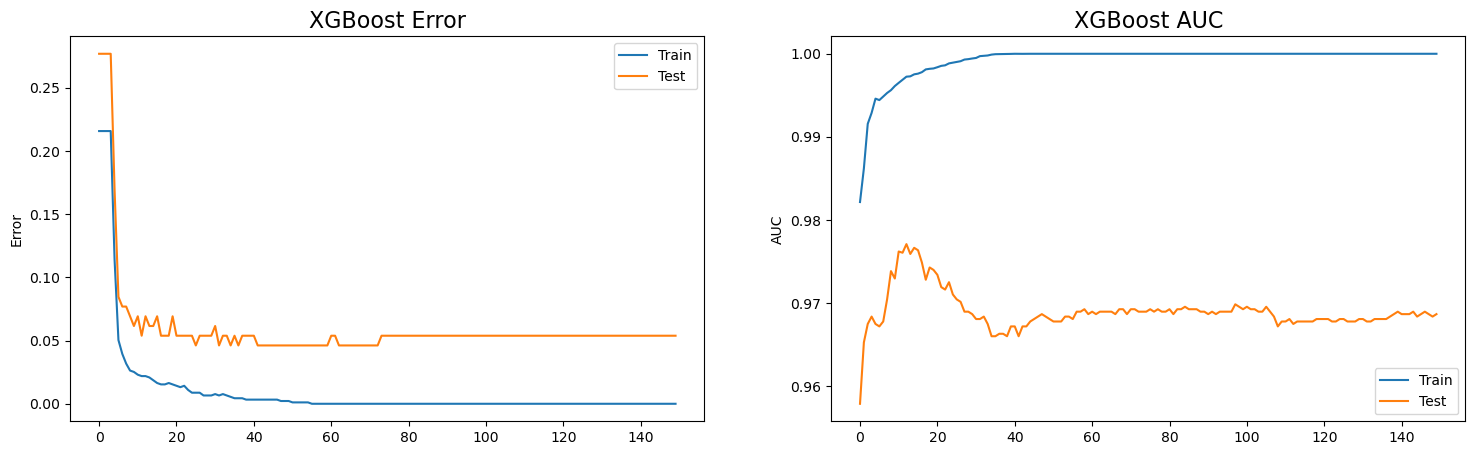

In [12]:
# retrieve performance metrics
results = xgb.evals_result()
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# plot log loss and classification error 
fig, axs = plt.subplots(ncols=2, figsize=(18, 5))

# plot log loss
axs[0].plot(x_axis, results['validation_0']['error'], label='Train')
axs[0].plot(x_axis, results['validation_1']['error'], label='Test')
axs[0].legend()
axs[0].set_ylabel('Error')
axs[0].set_title('XGBoost Error', fontsize=16)

# plot classification error
axs[1].plot(x_axis, results['validation_0']['auc'], label='Train')
axs[1].plot(x_axis, results['validation_1']['auc'], label='Test')
axs[1].legend()
axs[1].set_ylabel('AUC')
axs[1].set_title('XGBoost AUC', fontsize=16)

plt.show()


### Evaluate the fitted model

In [13]:
y_pred_train = xgb.predict(X_train)
y_pred_val = xgb.predict(X_valid)
y_pred_test = grid_search.predict(X_test)

y_train_prob = xgb.predict_proba(X_train)
y_val_prob = xgb.predict_proba(X_valid)
y_test_prob = xgb.predict_proba(X_test)

In [14]:
print(classification_report(y_valid,y_pred_val))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96        94
           1       0.85      0.97      0.91        36

    accuracy                           0.95       130
   macro avg       0.92      0.95      0.94       130
weighted avg       0.95      0.95      0.95       130



In [15]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       197
           1       0.94      0.91      0.92        65

    accuracy                           0.96       262
   macro avg       0.95      0.94      0.95       262
weighted avg       0.96      0.96      0.96       262



In [16]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       716
           1       1.00      1.00      1.00       197

    accuracy                           1.00       913
   macro avg       1.00      1.00      1.00       913
weighted avg       1.00      1.00      1.00       913



In [17]:
# Measure F1 score for training, validation and testing
print('Train Accuracy: %0.3f' % accuracy_score(y_train,y_pred_train))
print('Validation Accuracy: %0.3f' % accuracy_score(y_val,y_pred_val))
print('Test Accuracy: %0.3f' % accuracy_score(y_test,y_pred_test))

Train Accuracy: 1.000
Validation Accuracy: 0.946
Test Accuracy: 0.962


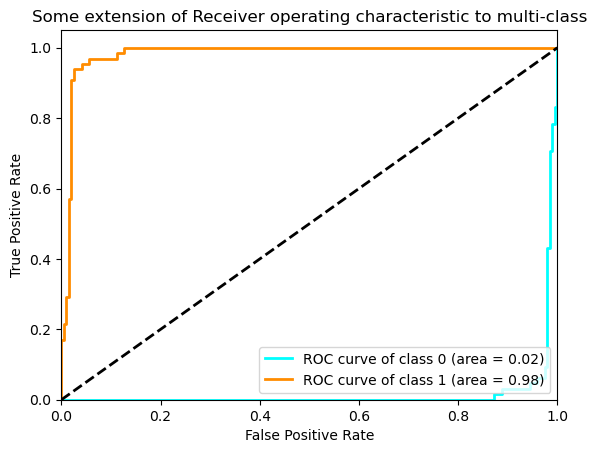

In [18]:
# Plot all ROC curves

from sklearn.preprocessing import label_binarize
#Calculate ROC curve and ROC each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y_bin = label_binarize(y_test, classes=[0,1])
n_classes =2

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_test_prob[:,i])
    roc_auc[i] = roc_auc_score(y_test, y_test_prob[:,i])
plt.figure()
lw=2
colors = cycle(['aqua', 'darkorange']) #, 'cornflowerblue' ]) #'deeppink','navy'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(le.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

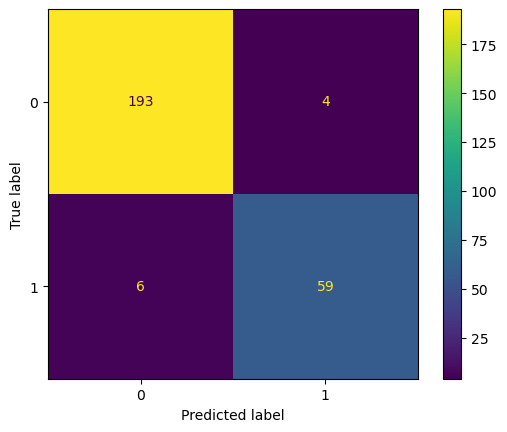

In [19]:
# plot confusion matrix for test set
cm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot();

In [20]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train)

In [21]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

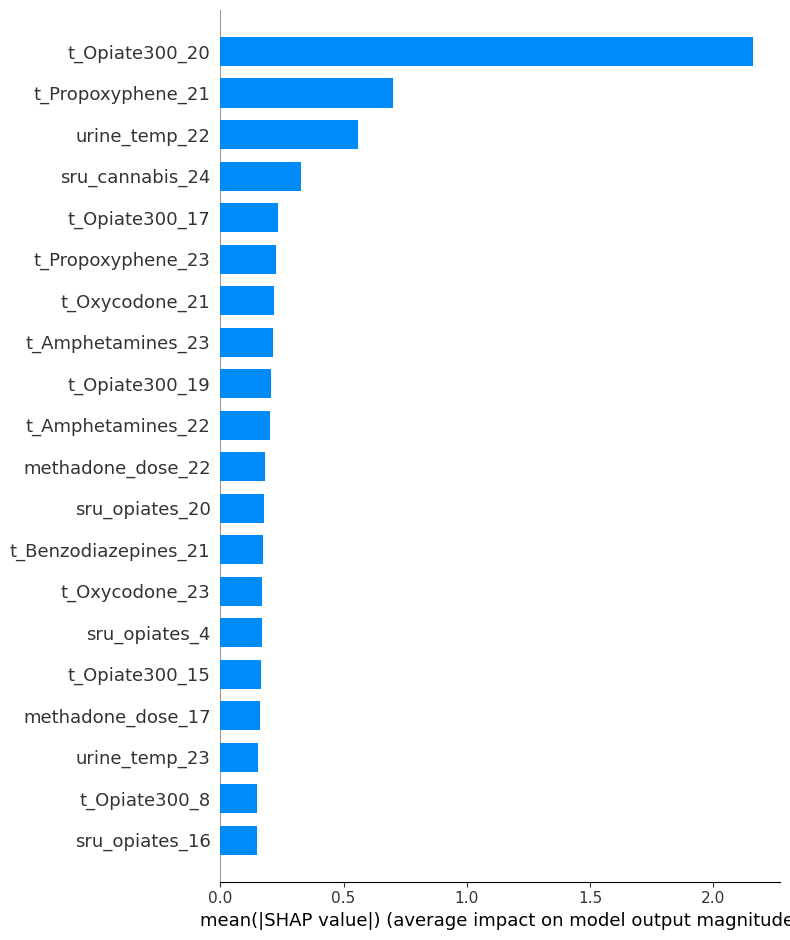

In [22]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

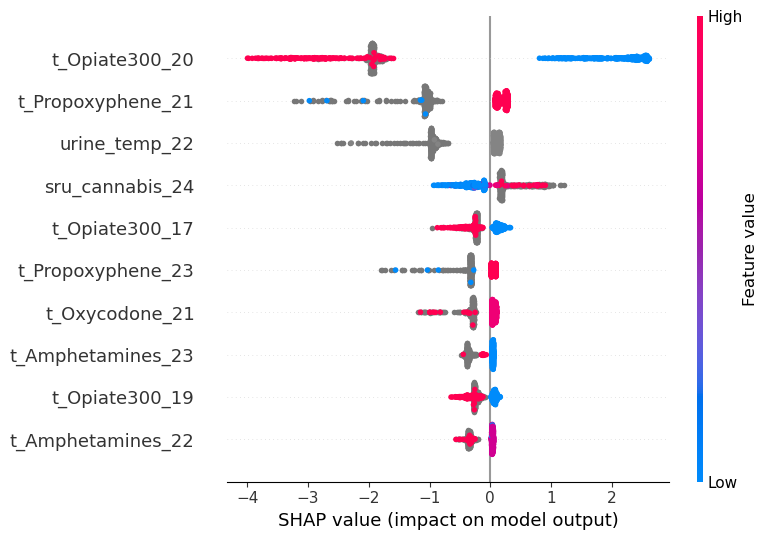

In [23]:
shap.summary_plot(shap_values, X_train, max_display=10)